In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer ,BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
import torch.nn as nn
import torch.optim as optim
from torch.hub import load
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsRegressor





In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path)
data.dropna(inplace=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)



In [4]:

# Basic exploration
print(f"Dataset shape: {data.shape}")
print("Columns:", data.columns)

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
# Focus on relevant columns
StringData = data[['directions', 'desc', 'rating']].copy()

StringDataWithNames=data[['directions', 'desc', 'rating']].copy()






In [6]:
# Handle nested structures and add column names before each value
string_columns = ['directions', 'desc']

for col in string_columns:
    StringDataWithNames[col] = StringDataWithNames[col].apply(
        lambda x: f"{col}: {', '.join(map(str, x))}" if isinstance(x, (list, np.ndarray)) else f"{col}: {x}" if pd.notnull(x) else x
    )



# Ensure all values are strings before concatenation
StringDataWithNames['Alltext'] = StringDataWithNames['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " [SEP] " + StringDataWithNames['desc'].apply(
    lambda x: str(x)
) 




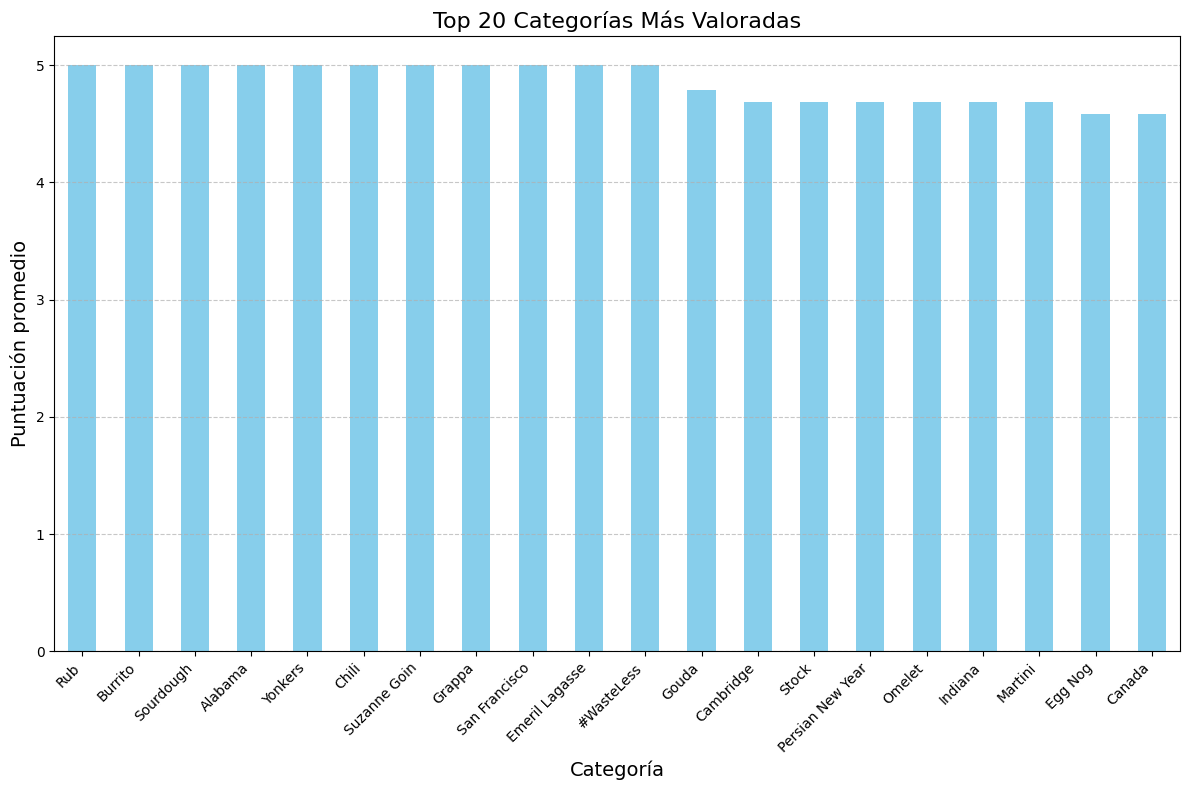

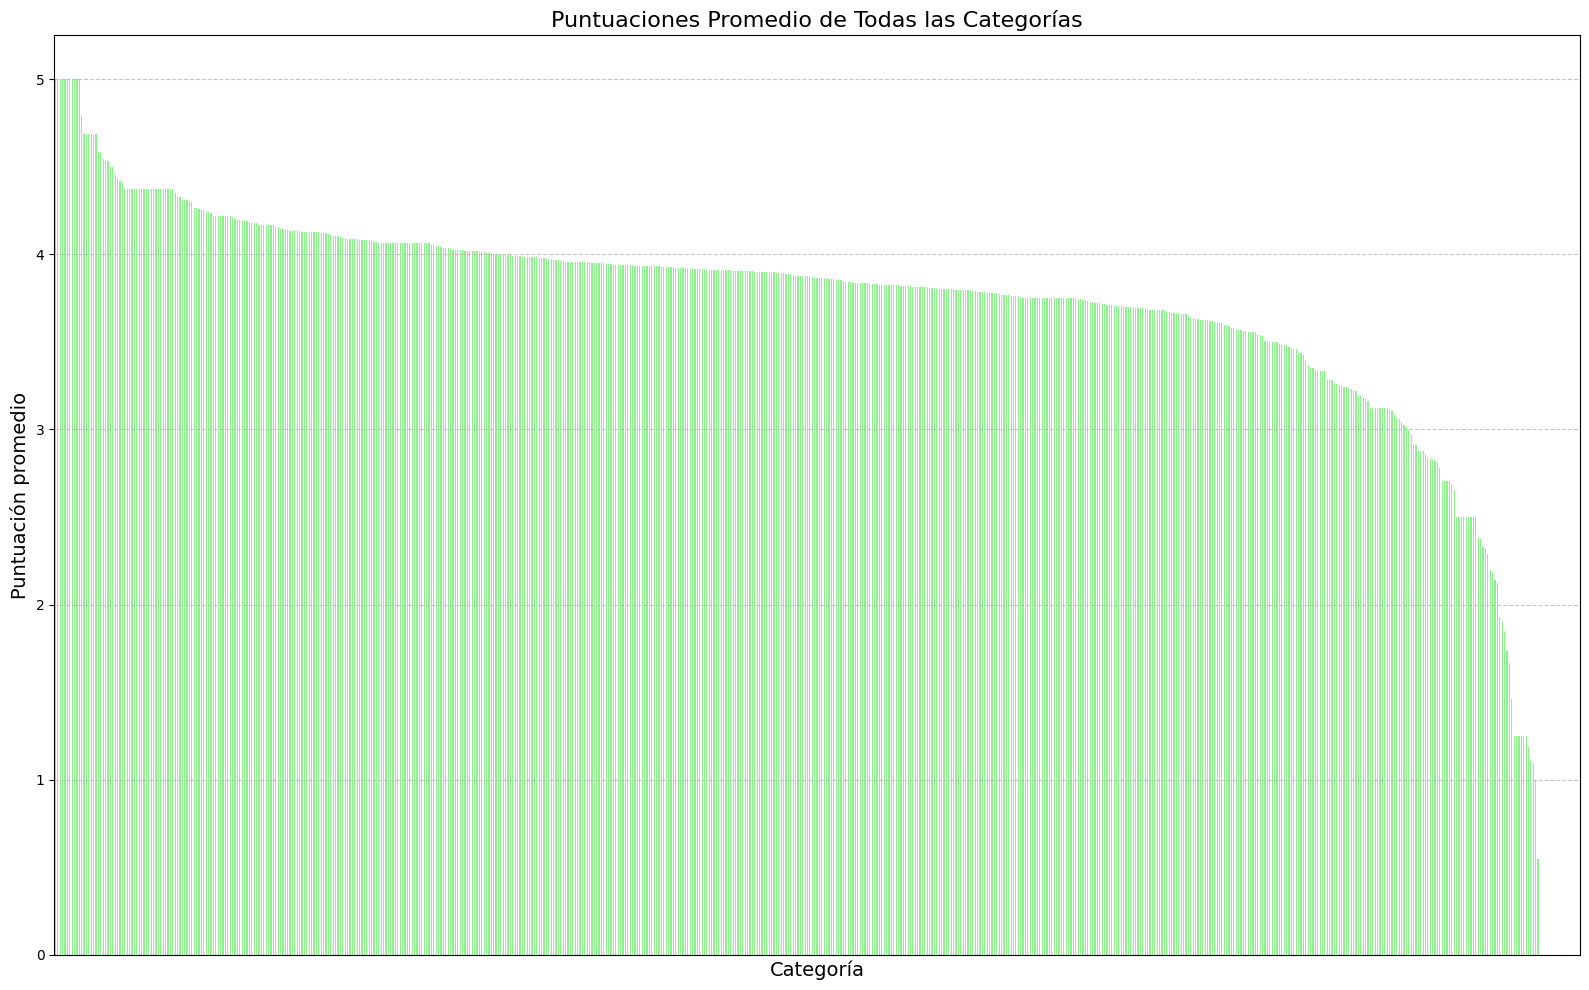

Número total de categorías únicas: 637


In [7]:


# Explode the 'categories' column and calculate mean ratings for each category
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Plot the top 20 categories
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all categories without x-axis labels
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Removes x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the total number of unique categories
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [8]:
# Text preprocessing function
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [9]:


# Apply preprocessing
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))







In [10]:
# # Extract and normalize numeric features
# numeric_features = data[['fat', 'protein', 'calories', 'sodium']]
# scaler = StandardScaler()
# numeric_features = scaler.fit_transform(numeric_features)

In [11]:
print(StringData[['processed_directions', 'processed_desc']].head())

                                processed_directions  \
0  simmer pea cream red pepper flake garlic teasp...   
1  Combine sugar orange juice concentrate water h...   
2  preheat oven F Butter flour cup Bundt pan Whis...   
3  heat peanut oil heavy large pot medium high he...   
4  stir ingredient small bowl blend season taste ...   

                                      processed_desc  
0  zing fresh lemon enhance pea sweetness natural...  
1           Orange syrup sweeten cake fresh fruit go  
2  brandied whip cream add perfect finishing touc...  
3  hearty stew like soup inspire vietnamese pho h...  
4                                 nice toasted bagel  


--------------------------------------------------------------------TF-IDF------------------------------------------------------------------

In [12]:
# TF-IDF vectorization for individual columns
vectorizer = TfidfVectorizer(max_features=100)
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])


In [13]:
#Convert data to X and Y combining numeric and written features
X_TFIDF = torch.tensor(
    pd.concat(
        [ pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray())],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [14]:
# Train-test-validation split
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(
   X_TFIDF, y, test_size=0.2, random_state=42)

X_val_TFIDF, X_test_TFIDF, y_val, y_test = train_test_split(
    X_test_TFIDF, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------WORD2VEC------------------------------------------------------------------

In [15]:
# Prepare data for Word2Vec
documents = StringData['processed_directions'].tolist() + StringData['processed_desc'].tolist()
tokenized_documents = [doc.split() for doc in documents]



In [16]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [17]:
# Function to calculate document embeddings
def get_doc_embedding(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [18]:

# Generate Word2Vec embeddings for each column
StringData['directions_w2v'] = StringData['processed_directions'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['desc_w2v'] = StringData['processed_desc'].apply(lambda x: get_doc_embedding(x, word2vec_model))


In [19]:

# Combine Word2Vec embeddings into a single feature matrix
w2v_features = np.array(StringData['directions_w2v'].tolist()) + \
               np.array(StringData['desc_w2v'].tolist())


In [20]:
#Convert data to X and Y combining numeric and written features
X_W2V = torch.tensor(
    pd.DataFrame(w2v_features).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

#
# final_features = np.hstack([w2v_features, numeric_features])


In [21]:
# Train-test split
X_train_W2V, X_test_W2V, y_train, y_test = train_test_split(
   X_W2V, y, test_size=0.2, random_state=42)
X_val_W2V, X_test_W2V, y_val, y_test = train_test_split(
    X_test_W2V, y_test, test_size=0.5, random_state=42)  

--------------------------------------------------------------------BERT------------------------------------------------------------------

In [22]:

# Using BERT embeddings for contextual embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [23]:
def get_bert_embeddings(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the CLS token embeddings as the document representation
    return outputs.last_hidden_state[:, 0, :].numpy()



In [24]:
#X_text_Prebert = StringDataWithNames['Alltext']
#X_embeddings = get_bert_embeddings(X_text_Prebert.tolist())
embeddings_directions = get_bert_embeddings(StringDataWithNames['directions'].tolist())
embeddings_desc = get_bert_embeddings(StringDataWithNames['desc'].tolist())

# Stack all features together
X_embeddings = np.hstack([
    embeddings_directions,
    embeddings_desc,
])





In [25]:
# Combine BERT embeddings and numeric features
X_BERT = torch.tensor(
    pd.concat(
        [pd.DataFrame(X_embeddings)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [26]:
# Split BERT
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_BERT, y, test_size=0.2, random_state=42)

X_val_bert, X_test_bert, y_val, y_test = train_test_split(
    X_test_bert, y_test, test_size=0.5, random_state=42)

-----------------------------------------------------------------------------Before Starting---------------------------------------------------------------------

In [27]:

# Calculate the mean of the 'rating' feature
mean_rating = StringData['rating'].mean()

# Create a prediction array with the mean value for all samples
predictions = np.full_like(StringData['rating'], mean_rating)

# Calculate the MAE
mae = mean_absolute_error(StringData['rating'], predictions)

print(f"Mean rating: {mean_rating}")
print(f"MAE when predicting the mean: {mae}")

Mean rating: 3.8045578808446456
MAE when predicting the mean: 0.828418629242508


--------------------------------------------------------------------KNN------------------------------------------------------------------

In [28]:

knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_TFIDF, y_train)

KNeighborsRegressor()

In [29]:
# Ensure X_test and y_test are numpy arrays
#X_test_bert_np = X_train_bert.cpu().numpy() if isinstance(X_train_bert, torch.Tensor) else X_train_bert
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_TFIDF)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:", mean_absolute_error(y_test, knn_predictions))

KNN MSE: 1.56815505027771
KNN MAE: 0.8272855877876282


In [30]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_W2V, y_train)

KNeighborsRegressor()

In [31]:
# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_W2V)
print("KNN MSE:", mean_squared_error(y_test, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test, knn_predictions))


KNN MSE: 1.5026508569717407
KNN MAE: 0.818331778049469


In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_bert, y_train)


KNeighborsRegressor()

In [33]:

# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
#y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_bert)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:",  mean_absolute_error(y_test,knn_predictions))


KNN MSE: 1.4914143085479736
KNN MAE: 0.8137370347976685


--------------------------------------------------------------------SIMPLE NN------------------------------------------------------------------

----------------------------------------------------------------------SIMPLE NN WITH W2V-----------------------------------------------------------

In [34]:
# Train a neural network using PyTorch
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



In [35]:
input_size = X_train_W2V.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [37]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")



Epoch 1, Training Loss: 4.119122505187988, Validation Loss: 4.010639190673828
Epoch 2, Training Loss: 3.960658550262451, Validation Loss: 3.8522419929504395
Epoch 3, Training Loss: 3.8065907955169678, Validation Loss: 3.701967239379883
Epoch 4, Training Loss: 3.66402006149292, Validation Loss: 3.5554587841033936
Epoch 5, Training Loss: 3.526455879211426, Validation Loss: 3.408766031265259
Epoch 6, Training Loss: 3.388937473297119, Validation Loss: 3.260359048843384
Epoch 7, Training Loss: 3.2499096393585205, Validation Loss: 3.110285520553589
Epoch 8, Training Loss: 3.1089041233062744, Validation Loss: 2.957855463027954
Epoch 9, Training Loss: 2.965573310852051, Validation Loss: 2.8025906085968018
Epoch 10, Training Loss: 2.819183826446533, Validation Loss: 2.6438698768615723
Epoch 11, Training Loss: 2.669299364089966, Validation Loss: 2.481870174407959
Epoch 12, Training Loss: 2.515810012817383, Validation Loss: 2.3170597553253174
Epoch 13, Training Loss: 2.3590641021728516, Validatio

In [38]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")



Neural Network Test Loss: 0.745982825756073
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.5059731006622314
 - Mean Absolute Error (MAE): 0.745982825756073


----------------------------------------------------------------------SIMPLE NN WITH TFIDF-----------------------------------------------------------

In [39]:
input_size = X_train_TFIDF.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [41]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 200  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.7840967178344727, Validation Loss: 3.8067147731781006
Epoch 2, Training Loss: 3.7583491802215576, Validation Loss: 3.779881000518799
Epoch 3, Training Loss: 3.732365846633911, Validation Loss: 3.752394914627075
Epoch 4, Training Loss: 3.705718755722046, Validation Loss: 3.724090337753296
Epoch 5, Training Loss: 3.6782805919647217, Validation Loss: 3.6948490142822266
Epoch 6, Training Loss: 3.649960994720459, Validation Loss: 3.66457200050354
Epoch 7, Training Loss: 3.620659112930298, Validation Loss: 3.6331465244293213
Epoch 8, Training Loss: 3.5902795791625977, Validation Loss: 3.6004910469055176
Epoch 9, Training Loss: 3.55873966217041, Validation Loss: 3.5665531158447266
Epoch 10, Training Loss: 3.5259783267974854, Validation Loss: 3.5312840938568115
Epoch 11, Training Loss: 3.4919424057006836, Validation Loss: 3.4946162700653076
Epoch 12, Training Loss: 3.45656681060791, Validation Loss: 3.45649790763855
Epoch 13, Training Loss: 3.4198081493377686, Validat

In [42]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7586802840232849
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4714994430541992
 - Mean Absolute Error (MAE): 0.7586802244186401


----------------------------------------------------------------------SIMPLE NN WITH BERT-----------------------------------------------------------

In [43]:
input_size = X_train_bert.shape[1]
model = SimpleNN(input_size).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)


In [45]:
# Training loop
best_val_loss = float('inf')  # Initialize to a large value
patience = 500  # Number of epochs to wait before stopping
tolerance = 1e-5  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(1000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")

Epoch 1, Training Loss: 3.771568775177002, Validation Loss: 2.7378365993499756
Epoch 2, Training Loss: 2.7205984592437744, Validation Loss: 1.7243491411209106
Epoch 3, Training Loss: 1.7316508293151855, Validation Loss: 0.8607378005981445
Epoch 8, Training Loss: 1.1494922637939453, Validation Loss: 0.793717622756958
Epoch 10, Training Loss: 0.9133440852165222, Validation Loss: 1.1089911460876465
Epoch 15, Training Loss: 0.8958771824836731, Validation Loss: 0.7754952311515808
Epoch 20, Training Loss: 0.9332449436187744, Validation Loss: 0.7788443565368652
Epoch 21, Training Loss: 0.821993350982666, Validation Loss: 0.7702558040618896
Epoch 27, Training Loss: 0.8276890516281128, Validation Loss: 0.759686291217804
Epoch 28, Training Loss: 0.7936201691627502, Validation Loss: 0.7583667039871216
Epoch 30, Training Loss: 0.8392356634140015, Validation Loss: 0.8070856332778931
Epoch 32, Training Loss: 0.817783772945404, Validation Loss: 0.7490091323852539
Epoch 39, Training Loss: 0.7889361381

In [46]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.7359368205070496
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4751464128494263
 - Mean Absolute Error (MAE): 0.7359368205070496


------------------------------------------------------------------------COMPLEX MODEL------------------------------------------------------------------

----------------------------------------------------------------------COMPLEX NN WITH W2V-----------------------------------------------------------

In [47]:


class ComplexNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=None, dropout_rate=0.3):
        super(ComplexNN, self).__init__()
        
        if hidden_sizes is None:
            hidden_sizes = [256, 128, 64]  # Default hidden layer sizes
        
        layers = []
        in_size = input_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            in_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], 1))
        
        # Define the sequential model
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)





In [48]:
input_size = X_train_W2V.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [49]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_W2V).float().to(device) if isinstance(X_train_W2V, np.ndarray) else X_train_W2V.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_W2V).float().to(device) if isinstance(X_val_W2V, np.ndarray) else X_val_W2V.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_W2V).float().to(device) if isinstance(X_test_W2V, np.ndarray) else X_test_W2V.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [50]:


# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.9072556495666504, Validation Loss: 3.8878402709960938
Epoch 2, Training Loss: 3.9030699729919434, Validation Loss: 3.8423967361450195
Epoch 3, Training Loss: 3.8762869834899902, Validation Loss: 3.812128782272339
Epoch 4, Training Loss: 3.8633530139923096, Validation Loss: 3.788965940475464
Epoch 5, Training Loss: 3.8694705963134766, Validation Loss: 3.7721426486968994
Epoch 6, Training Loss: 3.8607981204986572, Validation Loss: 3.7607192993164062
Epoch 7, Training Loss: 3.854865312576294, Validation Loss: 3.7512471675872803
Epoch 8, Training Loss: 3.8459746837615967, Validation Loss: 3.742966413497925
Epoch 9, Training Loss: 3.837371826171875, Validation Loss: 3.7348384857177734
Epoch 10, Training Loss: 3.8366992473602295, Validation Loss: 3.7228891849517822
Epoch 11, Training Loss: 3.8211348056793213, Validation Loss: 3.712104082107544
Epoch 12, Training Loss: 3.8163702487945557, Validation Loss: 3.699594736099243
Epoch 13, Training Loss: 3.8044872283935547,

In [51]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")


Neural Network Test Loss: 0.7087030410766602
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.4017447233200073
 - Mean Absolute Error (MAE): 0.7087031006813049


----------------------------------------------------------------------COMPLEX NN WITH TFIDF-----------------------------------------------------------

In [52]:
input_size = X_train_TFIDF.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [53]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_TFIDF).float().to(device) if isinstance(X_train_TFIDF, np.ndarray) else X_train_TFIDF.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_TFIDF).float().to(device) if isinstance(X_val_TFIDF, np.ndarray) else X_val_TFIDF.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_TFIDF).float().to(device) if isinstance(X_test_TFIDF, np.ndarray) else X_test_TFIDF.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [54]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6 # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.8336405754089355, Validation Loss: 3.829103946685791
Epoch 10, Training Loss: 3.7285523414611816, Validation Loss: 3.8528923988342285
Epoch 20, Training Loss: 3.641434669494629, Validation Loss: 3.915437936782837
Epoch 30, Training Loss: 3.514575958251953, Validation Loss: 3.829132318496704
Epoch 31, Training Loss: 3.4949934482574463, Validation Loss: 3.8151562213897705
Epoch 32, Training Loss: 3.4661855697631836, Validation Loss: 3.7973878383636475
Epoch 33, Training Loss: 3.465268135070801, Validation Loss: 3.7752537727355957
Epoch 34, Training Loss: 3.452064037322998, Validation Loss: 3.7537472248077393
Epoch 35, Training Loss: 3.4288573265075684, Validation Loss: 3.7298009395599365
Epoch 36, Training Loss: 3.4120755195617676, Validation Loss: 3.703721761703491
Epoch 37, Training Loss: 3.394481897354126, Validation Loss: 3.674640417098999
Epoch 38, Training Loss: 3.3860864639282227, Validation Loss: 3.644282341003418
Epoch 39, Training Loss: 3.3742821216583

In [55]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.666990339756012
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.1855558156967163
 - Mean Absolute Error (MAE): 0.6669902801513672


----------------------------------------------------------------------COMPLEX NN WITH BERT-----------------------------------------------------------

In [56]:
input_size = X_train_bert.shape[1]  # Input feature size
model = ComplexNN(input_size, hidden_sizes=[512, 256, 128], dropout_rate=0.4).to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0011)  # Optimizer

In [57]:
# Convert data to tensors
# Ensure tensors are created correctly without redundant wrapping
X_train_tensor = torch.from_numpy(X_train_bert).float().to(device) if isinstance(X_train_bert, np.ndarray) else X_train_bert.clone().detach().float().to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_train) else y_train.clone().detach().view(-1, 1).to(device)

X_val_tensor = torch.from_numpy(X_val_bert).float().to(device) if isinstance(X_val_bert, np.ndarray) else X_val_bert.clone().detach().float().to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_val) else y_val.clone().detach().view(-1, 1).to(device)

X_test_tensor = torch.from_numpy(X_test_bert).float().to(device) if isinstance(X_test_bert, np.ndarray) else X_test_bert.clone().detach().float().to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device) if not torch.is_tensor(y_test) else y_test.clone().detach().view(-1, 1).to(device)

In [58]:
# Initialize variables for early stopping
best_val_loss = float('inf')  # Initialize to a large value
patience = 1000  # Number of epochs to wait before stopping
tolerance = 1e-6  # Minimum improvement in validation loss to consider it better
no_improve_epochs = 0  # Counter for early stopping

# Save the best model
best_model_state = None

for epoch in range(5000):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)

    # Check for early stopping
    if val_loss.item() < best_val_loss - tolerance:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()  # Save the best model
        no_improve_epochs = 0  # Reset counter
    else:
        no_improve_epochs += 1

    # Logging
    if (epoch + 1) % 10 == 0 or no_improve_epochs == 0:
        print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Early stopping condition
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model after early stopping
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Model restored to the state from epoch with Validation Loss: {best_val_loss}")


Epoch 1, Training Loss: 3.825514554977417, Validation Loss: 3.8267178535461426
Epoch 10, Training Loss: 3.7265658378601074, Validation Loss: 3.8157482147216797
Epoch 11, Training Loss: 3.7249269485473633, Validation Loss: 3.812533140182495
Epoch 16, Training Loss: 3.682056427001953, Validation Loss: 3.7982842922210693
Epoch 17, Training Loss: 3.6858010292053223, Validation Loss: 3.7820703983306885
Epoch 18, Training Loss: 3.6568338871002197, Validation Loss: 3.7805280685424805
Epoch 19, Training Loss: 3.638711929321289, Validation Loss: 3.7786343097686768
Epoch 20, Training Loss: 3.640026807785034, Validation Loss: 3.7837462425231934
Epoch 24, Training Loss: 3.582721471786499, Validation Loss: 3.769071578979492
Epoch 25, Training Loss: 3.5734457969665527, Validation Loss: 3.7515108585357666
Epoch 30, Training Loss: 3.5033671855926514, Validation Loss: 3.738280773162842
Epoch 31, Training Loss: 3.497208833694458, Validation Loss: 3.719578504562378
Epoch 32, Training Loss: 3.481622219085

In [59]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): { mean_squared_error(y_test_np, test_predictions_np)}")
    print(f" - Mean Absolute Error (MAE): {mean_absolute_error(y_test_np, test_predictions_np)}")

Neural Network Test Loss: 0.6440528631210327
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.2168632745742798
 - Mean Absolute Error (MAE): 0.6440528631210327


------------------------------------------------------------------------FINE TUNNING FROM HUGGING FACE--------------------------------------------------------------------------

In [60]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=1)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:



# Split the encodings
#train_text, test_text, train_labels, test_labels = train_test_split(
#    StringDataWithNames['desc'].tolist(), StringDataWithNames['rating'].tolist(),test_size=0.2,random_state=42)

# Split the encodings
train_text, test_text, train_labels, test_labels = train_test_split(
    StringDataWithNames['Alltext'].tolist(), StringDataWithNames['rating'].tolist(),test_size=0.2,random_state=42)

validation_text, test_text, validation_labels, test_labels = train_test_split(
    test_text, test_labels,test_size=0.2,random_state=42)

Train_encodings = tokenizer(train_text,truncation=True, padding=True, max_length=128)
validation_encodings = tokenizer(validation_text,truncation=True, padding=True, max_length=128)
Test_encodings = tokenizer(test_text,truncation=True, padding=True, max_length=128)




In [62]:

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels  # Labels can be None for predictions

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = Dataset(Train_encodings, train_labels)
validation_dataset = Dataset(validation_encodings, validation_labels)
test_dataset = Dataset(Test_encodings)

In [ ]:
training_args = TrainingArguments(
output_dir='./results', # Directorio de salida
num_train_epochs=5, # Epocas
per_device_train_batch_size=16, # Batch entrenamiento
per_device_eval_batch_size=64, # Batch evaluacion
warmup_steps=500, # Steps de calentamiento
weight_decay=0.01, # Decaimiento del peso
logging_dir='./logs', # Directorio de logs
logging_steps=10,
)

trainer = Trainer(
model=model, # Modelo preentrenado
args=training_args, # Argumentos de entrenamiento
train_dataset=train_dataset, # Datos de entrenamiento
eval_dataset=validation_dataset # Datos de evaluacion
)
# Iniciar el fine-tuning
trainer.train()

  0%|          | 0/5310 [00:00<?, ?it/s]

{'loss': 16.4046, 'grad_norm': 154.7670440673828, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'loss': 14.2705, 'grad_norm': 129.8746795654297, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'loss': 12.0252, 'grad_norm': 124.33832550048828, 'learning_rate': 3e-06, 'epoch': 0.06}
{'loss': 10.1478, 'grad_norm': 121.36942291259766, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}
{'loss': 7.5647, 'grad_norm': 88.2143783569336, 'learning_rate': 5e-06, 'epoch': 0.09}
{'loss': 6.0895, 'grad_norm': 105.48039245605469, 'learning_rate': 6e-06, 'epoch': 0.11}
{'loss': 3.9722, 'grad_norm': 66.25725555419922, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.13}
{'loss': 2.7396, 'grad_norm': 33.80996322631836, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.15}
{'loss': 1.769, 'grad_norm': 20.319875717163086, 'learning_rate': 9e-06, 'epoch': 0.17}
{'loss': 1.814, 'grad_norm': 21.20785903930664, 'learning_rate': 1e-05, 'epoch': 0.19}
{'loss': 1.1044, 'grad_norm': 16.

In [67]:

trainer.evaluate()
# Guardar el modelo fine-tuned
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

  0%|          | 0/27 [00:00<?, ?it/s]

('./fine-tuned-bert\\tokenizer_config.json',
 './fine-tuned-bert\\special_tokens_map.json',
 './fine-tuned-bert\\vocab.txt',
 './fine-tuned-bert\\added_tokens.json')

In [68]:
predictions = trainer.predict(test_dataset)

# Extract logits and convert to probabilities (for binary classification) or labels (for multiclass)
logits = predictions.predictions

# For binary classification with `num_labels=1`
preds = logits.squeeze()  # If single logit per example
predicted_ratings = torch.sigmoid(torch.tensor(preds)).numpy()

# For multiclass classification with `num_labels=2`
# preds = np.argmax(logits, axis=1)

# Compute MAE
mae = mean_absolute_error(test_labels, predicted_ratings)
print(f"Mean Absolute Error (MAE): {mae}")

  0%|          | 0/7 [00:00<?, ?it/s]

Mean Absolute Error (MAE): 2.9846904277801514
